In [15]:
from spyral_utils.plot import CutHandler, Histogrammer
from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.particle_id import deserialize_particle_id, ParticleID
from spyral.core.constants import DEG2RAD
from spyral.core.run_stacks import form_run_string

import polars as pl
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from pathlib import Path

%matplotlib widget

RAD2DEG = 1.0/DEG2RAD

import numpy as np

In [16]:
# Load config
workspace_path = Path("c:\\Users\\schaeffe\\Desktop\\e20009_analysis-output")
estimation_result_path = workspace_path / "Estimation"

# Set the run range (inclusive)
run_min = 108
run_max = 320

# IC gate
ic_min_val = 900
ic_max_val = 1300

# Nucleus map
nuclear_map = NuclearDataMap()
grammer = Histogrammer()

In [17]:
pid_x_axis = "sqrt_dEdx" # This is the PID x-axis, matching a column name in the estimation dataframe
pid_y_axis = "brho" # This is the PID y-axis, matching a column name in the estimation dataframe

In [18]:
grammer.add_hist2d("particle_id_IC_gate", (400, 400), ((-10.0, 100), (-0.1, 2.5)))

for run in range(run_min, run_max+1):
# for run in range(121, 186):
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pl.scan_parquet(run_path)

    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    df = df.collect()

    grammer.fill_hist2d('particle_id_IC_gate', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy()) # Use your custom axes

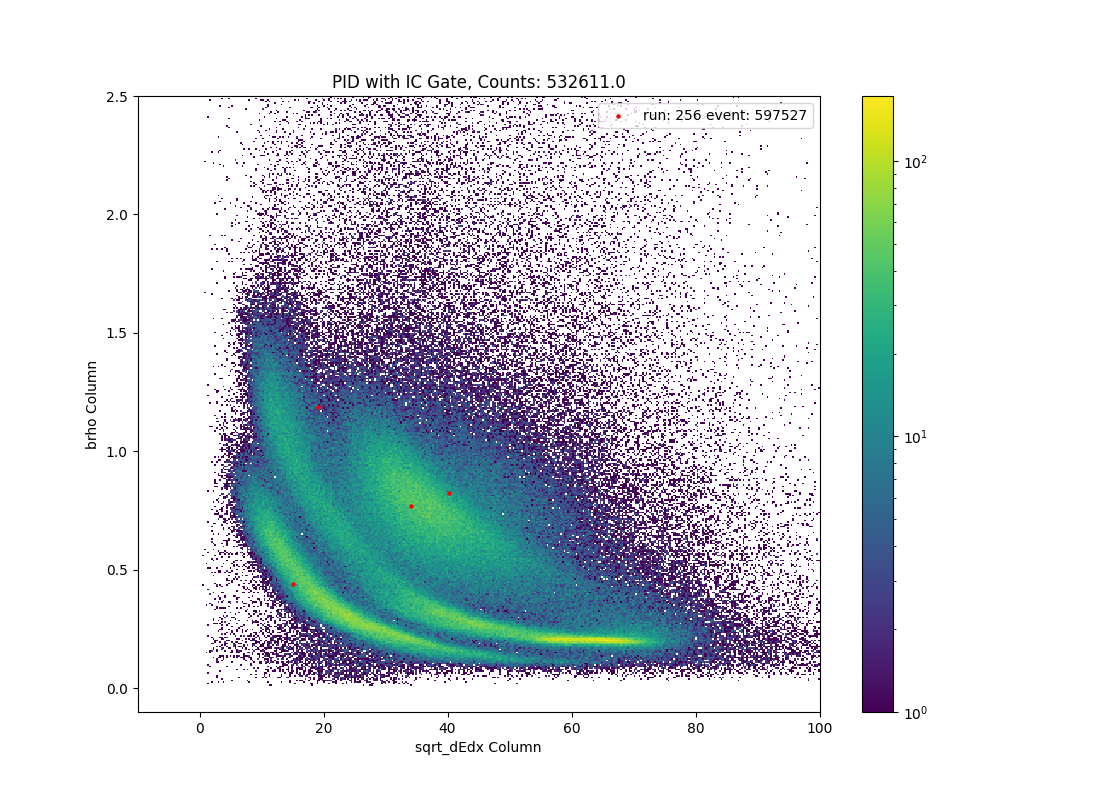

In [19]:
# Plot PID and draw gate by clicking points on plot
particle_id_IC_gate_hist = grammer.get_hist2d("particle_id_IC_gate")
fig, ax = plt.subplots(1,1)
# _ = PolygonSelector(ax, handler.mpl_on_select)
mesh = ax.pcolormesh(particle_id_IC_gate_hist.x_bins, particle_id_IC_gate_hist.y_bins, particle_id_IC_gate_hist.counts, norm='log')
# mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts)

### Below Used to overlay individual events on top of PID ###

points = np.loadtxt("C:\\Users\\schaeffe\\Desktop\\e20009-analysis\\notebooks\\results_256_597527_w_sqrt.txt", delimiter=",")  # Adjust filename if necessary
x_points = points[:, 0]  # First column
y_points = points[:, 1]  # Second column
plt.scatter(x_points, y_points, color='red', label='run: 256 event: 597527', s=5)
# plt.scatter(36.79498920831657, 0.9075735226642032, color="blue", label="HDBSCAN Original Clustering")
plt.legend()

### END ###
counts = 0
for bin in sum(particle_id_IC_gate_hist.counts):
    counts += bin

# print(counts)

fig.colorbar(mesh, ax=ax)
ax.set_title(f"PID with IC Gate, Counts: {counts}")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [14]:
def load_run_events(file_path):
    run_events = {}
    with open(file_path, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                # Split the line into run number and events
                run_part, events_part = line.split(", Events: ")
                run = int(run_part.split(": ")[1])
                events = [int(evt) for evt in events_part.split(", ")]
                run_events[run] = events
    return run_events

path_to_run_events = "C:\\Users\\schaeffe\\Desktop\\e20009_analysis-dev_1_18_2025\\e20009_analysis-dev\\notebooks\\evetns_14.5_to_16_MeV_range.txt"

run_events_dict = load_run_events(path_to_run_events)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\schaeffe\\Desktop\\e20009_analysis-dev_1_18_2025\\e20009_analysis-dev\\notebooks\\evetns_14.5_to_16_MeV_range.txt'

In [ ]:
print((run_events_dict))

{108: [12625, 897, 15744, 995, 7517, 18721, 17465, 21076, 1065, 13755, 9093, 9122, 19546, 2147], 109: [45522, 38421, 43046, 37412, 37499, 34102, 40105], 110: [59282, 55471, 48517, 48694, 51713, 49447, 57772, 48097, 46693], 112: [86424, 105501, 94326, 78255, 95547, 103029, 79612, 107594, 112270, 67384, 95226, 73132, 70662, 77504, 67450, 83246, 73127, 103616, 102814, 97306, 93412, 110817, 112734, 90589, 69039, 110893, 67937, 108265, 98696, 86877, 91181, 113020, 92608, 72508, 67475, 102612, 108514, 75963, 112718, 66482, 71880, 79963, 103019, 101957], 113: [129943, 156783, 128933, 117540, 175349, 138650, 117531, 115244, 173012, 140396, 142491, 119017, 120594, 158715, 133527, 164259, 168981, 150452, 124830, 155517, 124004, 153581, 175000, 117807, 150890, 126769, 160783, 169880, 129422, 135699, 171033, 131449, 173324, 130129, 144459, 168208, 154701, 173787, 117246, 124170, 137300, 122247, 169724, 165729, 114369, 132525, 162744, 173735, 166728, 171513, 151974, 130354, 123023], 114: [182162, 2

In [ ]:
grammer.add_hist2d("particle_id_gated_on_IC_and_energy_range", (400, 400), ((-10.0, 100.0), (-0.1, 2.5))) # Plot of dEdx vs. Brho (particle ID), gated on PID

for run in range(run_min, run_max+1):
    if run in run_events_dict.keys():
        # print(run)
        events_list = run_events_dict[run]
        # print(events_list)
        # count += len(events_list)

        run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
        if not run_path.exists():
            continue
        df = pl.scan_parquet(run_path)

        df = df.filter(
    (pl.col('event').is_in(events_list)) & 
    (pl.col('ic_amplitude') > ic_min_val) & 
    (pl.col('ic_amplitude') < ic_max_val)
)
        
        df = df.collect()

        grammer.fill_hist2d('particle_id_gated_on_IC_and_energy_range', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy()) # Use your custom axes

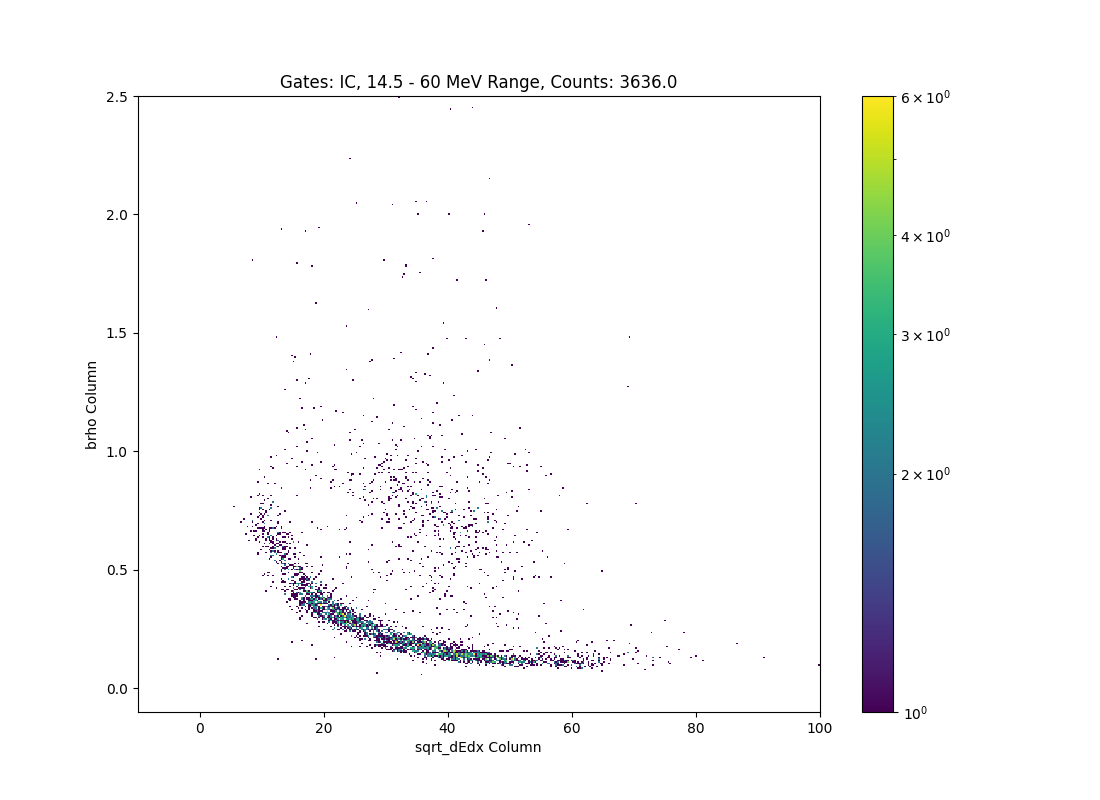

In [ ]:
# Plot gated PID
particle_id_gated_on_IC_and_energy_range = grammer.get_hist2d("particle_id_gated_on_IC_and_energy_range")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(particle_id_gated_on_IC_and_energy_range.x_bins, particle_id_gated_on_IC_and_energy_range.y_bins, particle_id_gated_on_IC_and_energy_range.counts , norm='log')
fig.colorbar(mesh, ax=ax)


counts_2 = 0
for bin in sum(particle_id_gated_on_IC_and_energy_range.counts):
    counts_2 += bin

ax.set_title(f"Gates: IC, 14.5 - 60 MeV Range, Counts: {counts_2}")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [ ]:
# Apply particle PIP

path_to_PID = Path("C:\\Users\\schaeffe\\Desktop\\e20009_analysis-dev_1_18_2025\\e20009_analysis-dev\\notebooks\\B10(d,p)\\triton_particle_id_subset_bigger.json")

particle_gate = deserialize_particle_id(path_to_PID, nuclear_map)

In [ ]:
print(particle_gate.cut)

In [ ]:
event_with_tritons = []  # Initialize the list

grammer.add_hist2d("particle_id_gated_on_energy_and_particle_band", (400, 400), ((-1.0, 100), (-0.1, 2.5))) # Plot of dEdx vs. Brho (particle ID), gated on PID

for run in range(run_min, run_max+1):
    if run in run_events_dict.keys():
        # print(run)
        events_list = run_events_dict[run]
        # print(events_list)
        # count += len(events_list)

        run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
        if not run_path.exists():
            continue
        df = pl.scan_parquet(run_path)

        df = df.filter(
    (pl.col('event').is_in(events_list)) & 
    (pl.col('ic_amplitude') > ic_min_val) & 
    (pl.col('ic_amplitude') < ic_max_val) &
    pl.struct([pid_x_axis, pid_y_axis]).map_batches(particle_gate.cut.is_cols_inside)
)
        
        df = df.collect()

        grammer.fill_hist2d('particle_id_gated_on_energy_and_particle_band', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy()) # Use your custom axes

     # Extract (run, event) pairs that passed all filters
        passed_events = df.select('event').to_series().to_list()
        event_with_tritons.extend([(run, event) for event in passed_events])

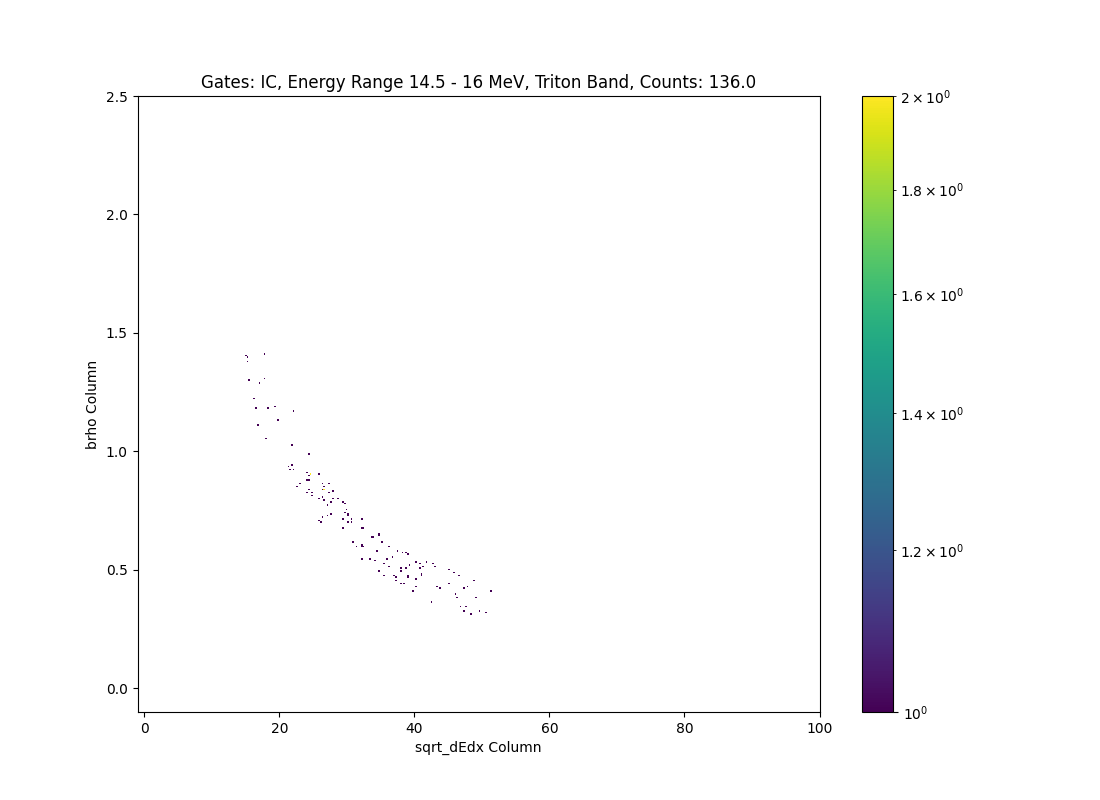

In [ ]:
# Plot gated PID
particle_id_gated_on_energy_and_particle_band = grammer.get_hist2d("particle_id_gated_on_energy_and_particle_band")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(particle_id_gated_on_energy_and_particle_band.x_bins, particle_id_gated_on_energy_and_particle_band.y_bins, particle_id_gated_on_energy_and_particle_band.counts , norm='log')
fig.colorbar(mesh, ax=ax)

counts_3 = 0
for bin in sum(particle_id_gated_on_energy_and_particle_band.counts):
    counts_3 += bin

### Below Used to overlay individual events on top of PID ###

# points = np.loadtxt("C:\\Users\\schaeffe\\Desktop\\e20009_analysis-dev_1_18_2025\\e20009_analysis-dev\\notebooks\\273_1491801\\results_273_1491801_w_sqrt.txt", delimiter=",")  # Adjust filename if necessary
# x_points = points[:, 0]  # First column
# y_points = points[:, 1]  # Second column
# plt.scatter(x_points, y_points, color='red', label='273_1491801 force clustered', s=10)

# plt.scatter(27.09713725806363, 0.8467527289562756, color='green', s= 10 ,label= "273_1491801, HDBSCAN original triton cluster")
# plt.legend()

### END ###


ax.set_title(f"Gates: IC, Energy Range 14.5 - 16 MeV, Triton Band, Counts: {counts_3}")
# ax.set_title("PID Gated")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [ ]:
print(len(event_with_tritons))
for e in event_with_tritons:
    print (e)

136
(109, 37412)
(109, 45522)
(114, 204648)
(115, 231137)
(115, 231574)
(115, 274863)
(117, 319064)
(118, 342386)
(121, 466966)
(121, 474116)
(122, 541674)
(122, 550875)
(122, 554531)
(124, 670576)
(124, 676635)
(125, 681818)
(125, 681818)
(181, 8614)
(182, 77268)
(182, 129229)
(183, 163771)
(183, 170576)
(183, 195271)
(183, 206487)
(184, 214969)
(184, 215373)
(184, 215373)
(184, 232736)
(184, 253168)
(185, 268996)
(185, 276618)
(207, 54789)
(207, 60826)
(207, 114739)
(208, 137459)
(208, 154289)
(208, 187430)
(208, 201746)
(249, 9608)
(249, 18626)
(249, 27199)
(249, 71312)
(250, 128416)
(250, 146618)
(250, 156595)
(252, 366882)
(253, 406149)
(253, 439497)
(253, 454029)
(256, 577499)
(256, 599920)
(259, 637276)
(260, 782009)
(260, 783165)
(260, 784408)
(262, 867312)
(262, 878515)
(263, 931996)
(264, 1039077)
(264, 1066973)
(264, 1070606)
(265, 1088563)
(265, 1102324)
(267, 1209631)
(269, 1259620)
(269, 1266474)
(270, 1296051)
(271, 1364765)
(272, 1438842)
(272, 1443401)
(273, 1506262)
(

In [ ]:
with open("evetns_with_tritons.txt", "w") as f:
    for run, event in event_with_tritons:
        f.write(f"{run},{event}\n")